# Quantum Addition
Addition is a fundamental operation which quantum computers are able to replicate through a variety of algorithms. A computer performs addition in a bitwise fashion operating on two bits at a time and utilizing additional carry bits to carry resulting values to be used in addition. For example, to get the result of $3+1$, we look at their binary representations, $3=011$ and $1=001$ which results in $4=100$.

To perform this operation classically, we first look at what is known as a "ripple-carry" adder. In quantum computing, there are very similar adder constructions albeit with a few distinct differences, so it is best to make sure that classical adders are fully understood.

We first start by constructing a simple half-adder. The half-adder takes in two inputs $a$ and $b$ representing the two bits we wish to add together. The half adder also has two outputs which 

Current quantum algorithms for addition is performed through one of two methodologies:
- Addition within phase space (or Fourier basis) 
- Addition within the computational basis

In [1]:
from qiskit import QuantumCircuit
from numpy import pi

## QFT-based Addition
QFT addition is addition which is done in what is often called the Fourier basis.

To grasp how addition is performed in this Fourier basis, we first need to understand what this basis is as well as the transform that gets us there. This transform is known as the quantum fourier transform (QFT). IBM has written a lovely guide on this matter complete with animations which can be found in their textbook [here](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html). For the following methodologies, we always start in the Fourier basis, then perform our operation.

### QFT Implementation
Below is an implementation of the quantum fourier transform.

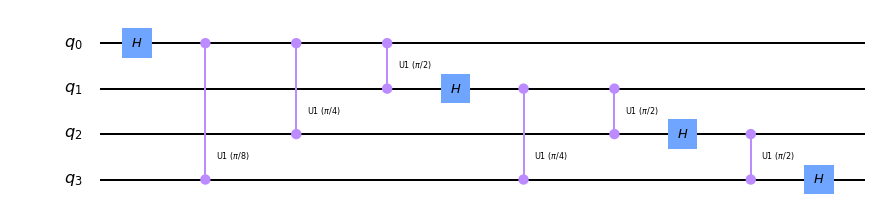

In [2]:
def __qft_base(n, sign):
    qc = QuantumCircuit(n)

    for qubit in range(n):
        qc.h(qubit)
        for control in range(n, qubit+1, -1):
            qc.cu1(sign * pi/2**(control-(1+qubit)), control-1, qubit)
 
    return qc

def qft_inst(n):
    qc = __qft_base(n, 1)
    qc.name = 'qft'
    return qc.to_instruction()

def qft_dag_inst(n):
    qc = __qft_base(n, -1)
    qc = qc.mirror()
    qc.name = 'qft-dag'
    return qc.to_instruction()

__qft_base(4, 1).draw('mpl') # Default QFT algorithm for 4 qubits

#### Flip
We need a circuit to shuffle the resulting qubits.

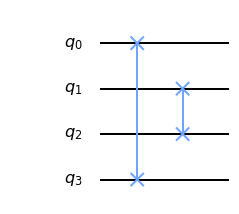

In [3]:
def flip(n):
    qc = QuantumCircuit(n, name='flip')
    
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
        
    return qc

flip_inst = lambda x: flip(x).to_instruction()

flip(4).draw('mpl')

### Draper Adder
This form of a quantum adder is highly efficient in that, with suitable classical networking, you can add $a+b$ without any ancillary qubits. The downside is that for $n$ qubits (e.g. number representation up to $2^n-1$), the system requires gates with perfect rotation precision in the $Z$ axis down to $\frac{\pi}{2^{n-1}}$ rotations. The full paper which this is based off of can be found [here](https://arxiv.org/pdf/quant-ph/0008033.pdf).

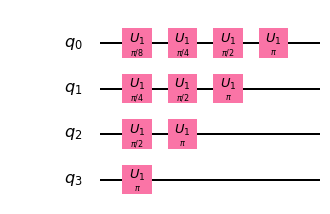

In [4]:
def draper_adder(qc, b):
    len_b = len(b)

    if len_b is 0:
        return qc

    if b[0] == '1':
        for val in range(len_b):
            qc.u1(pi/2**(len_b - val - 1), val)

    draper_adder(qc, b[1:])
    
def draper_adder_inst(b):
    qc = QuantumCircuit(len(b), name='draper-add')
    draper_adder(qc, b)
    return qc.to_instruction()

qc = QuantumCircuit(4)
draper_adder(qc, '1111')
qc.draw('mpl')

### Gradient

A simpler way to define the adder (at least programmatically) is to consolidate the rotations for each qubit into a single gate rotation. By consolidating the operations in this way, it becomes easy to produce our gate operations within a single "for" loop with no additional helper methods or conditionals.

We modify the circuit to take in a "size" parameter which defines the full size of the gradient gate and a "t" parameter which defines the amount to rotate by.

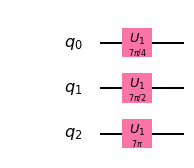

In [5]:
def gradient(size, theta):
    volume = 1/(1 << size) * pi * theta

    qc = QuantumCircuit(size, name='grad')
    for i in range(size):
        qc.u1(((2 << i) * volume), i)

    return qc

gradient_gate = lambda size, theta: gradient(size, theta).to_gate()

gradient(3, 7).draw('mpl')

### Full Gradient Operation

Given the gradient operation, we can now define a circuit which we can use to test our adder. This circuit is comprised of multiple stages, one of which is the gradient operation we defined above. The stages are as follows:
- QFT       - Convert from computational basis to Fourier basis
- Gradient  - Add the value via the gates
- QFT-DAG   - The adjoint of the QFT; used to take the qubits out of the Fourier basis and back into the computational basis
- Flip      - Reverses the order of the qubits; including this option converts our readout to big endian which is more conventional

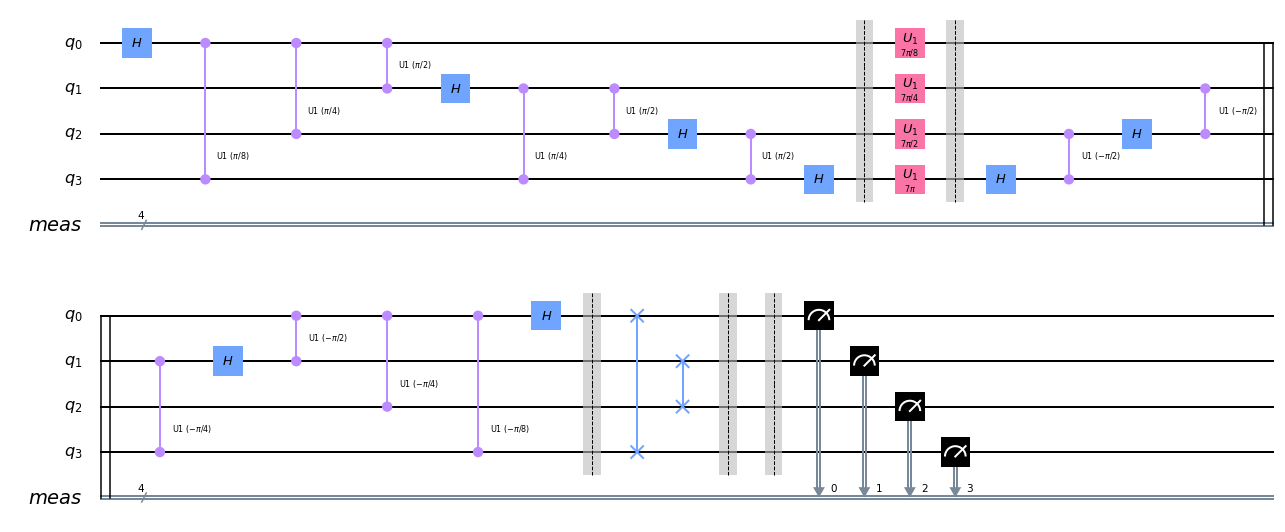

In [6]:
def gradient_full(size):
    m_qft_inst = qft_inst(size)
    m_qft_dag_inst = qft_dag_inst(size)
    m_flip_inst = flip_inst(size)

    def gradient_full_lambda(theta):
        qc = QuantumCircuit(size, name='grad_full')
        m_gradient = gradient_gate(size, theta)

        for circ in [m_qft_inst, m_gradient, m_qft_dag_inst, m_flip_inst]:
            qc.append(circ, range(size))
            qc.barrier()
        qc.measure_all()

        return qc

    return gradient_full_lambda

gradient_full(4)(7).decompose().draw('mpl')

We define a function to set the incoming qubits to a given state representing a number in binary. We perform conditionally flip the bits from the $|0\rangle$ state to the $\mid 1\rangle$ state via $X$ gates to achieve the desired "classical" binary value on the wire. This value will then be encoded into the Fourier basis via the QFT operation.

In [7]:
def setup_qc(size, val):
    qc = QuantumCircuit(size, name='setup')
    for shft in range(size):
        qc.rx((val >> shft) % 2 * pi, size - shft - 1)

    return qc

Next, we define a imports which we will use for circuit construction as well as the simulator.

In [8]:
from qiskit import BasicAer, transpile, execute

This helper function transpiles the circuit and executes it as well as returning the raw counts.

In [9]:
def transpile_test_circ(circ, shot_count=1024):
    transpiled_qc = transpile(circ)
    
    return lambda x={}: execute(transpiled_qc, backend=BasicAer.get_backend('qasm_simulator'), parameter_binds=x, shots=shot_count).result().get_counts()

In [10]:
import time
from qiskit.circuit import Parameter

### Testing

For testing, we define a test function which, when given a value of $n$, runs all possible additions $i+j$ up to $2^{n-1}$. To accomodate for the carry bit, we create a circuit of size n+1 (e.g. a circuit of size 3 cannot add $7+7$ ($b111 + b111 = b1110$)). Every possible addition circuit as well as all possible setup circuits are assembled before the test runs. Then, each test is a combination of a given setup and a given test. This allows the testing of all possible values of $i, j$.

In [11]:
def test_grad_inst(n=4):
    n_range = range(2**n)
    circ_size = n + 1

    theta = Parameter('theta')
    test_gradient_qc = gradient_full(circ_size)(theta)

    parameterized_gradient_qcs = [ setup_qc(circ_size, i) + test_gradient_qc for i in n_range ]

    # Tests each possible value of i + j.
    for i in n_range:
        job = transpile_test_circ(parameterized_gradient_qcs[i])
        res = job([{theta: j} for j in n_range]) # Run circuit with value 'i' against gradient with value 'j' for all values of 'j'

        # Evaluate the answers
        for j in n_range:
            expected = i + j
            actual = int(list(res[j].keys())[0], 2)

            assert expected == actual, f"Expected {i}+{j}={expected}\tGot: {actual}"

start = time.time()
test_grad_inst()
end = time.time()
print ("Testing complete! Elapsed: ", end-start)

Testing complete! Elapsed:  6.355870723724365
